### Random Walk while inserting the coordinates/movement direction to the CNN and RNN
Here I will try to insert the direction of the path taken to the networks. 
<br> So... if our Syclop move in the following trajectory: [x,y]
<br> [36, 36],
<br>        [33, 37],
<br>        [34, 39],
<br>[35, 39],
<br>       [36, 40])
<br> I will concatinate the [x,y] values to the network state after the CNN network and before the RNN or FC networks. 
<br> We can also insert the destination and the source - [x_t,y_t],[x_t-1, y_t-1]


In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle

In [2]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/bnapp/arivkindNet/or_branch/imagewalker/misc.py'>

In [3]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/bnapp/datasets/mnist/')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc

#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

### Show an example of Syclop path and outputs:

In [4]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [5]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [6]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [36, 40],
       [38, 38],
       [33, 42],
       [31, 37]])

In [7]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


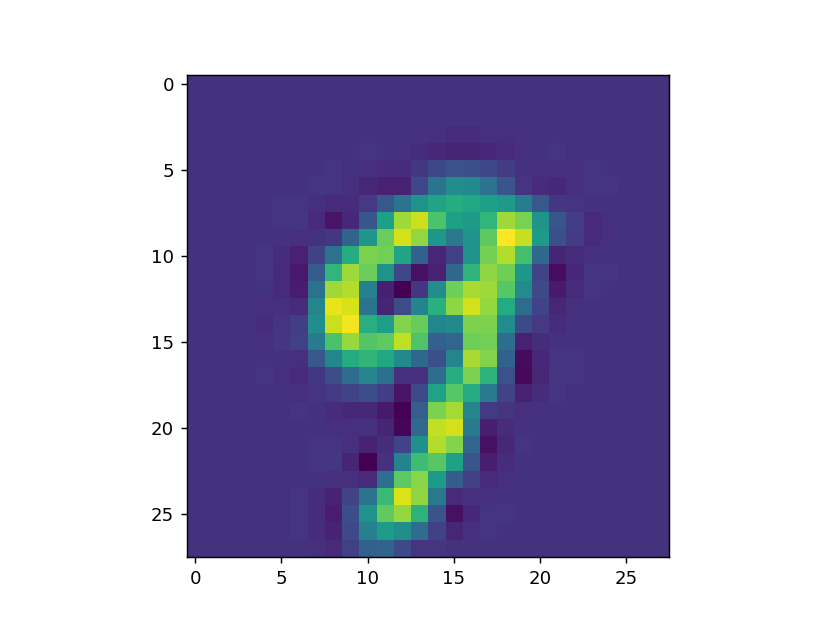

<IPython.core.display.Javascript object>


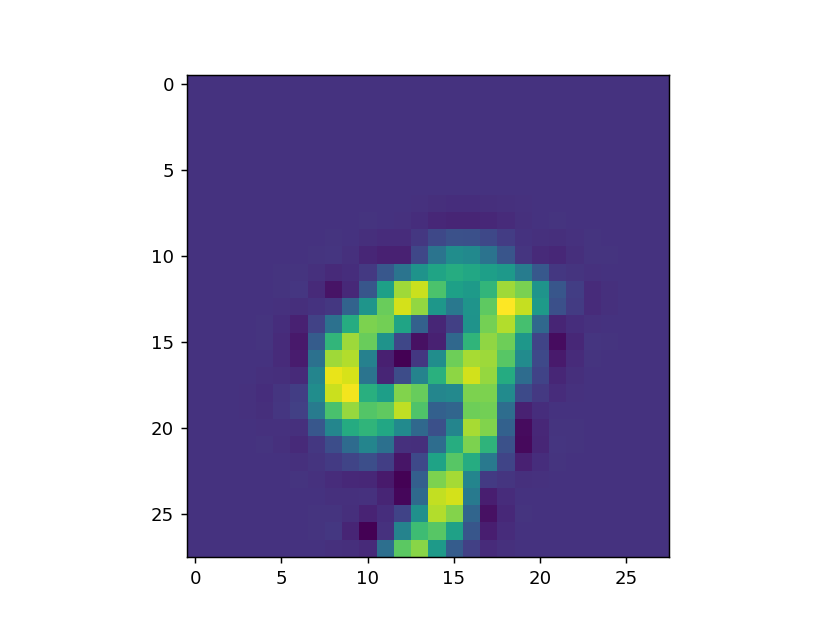

<IPython.core.display.Javascript object>


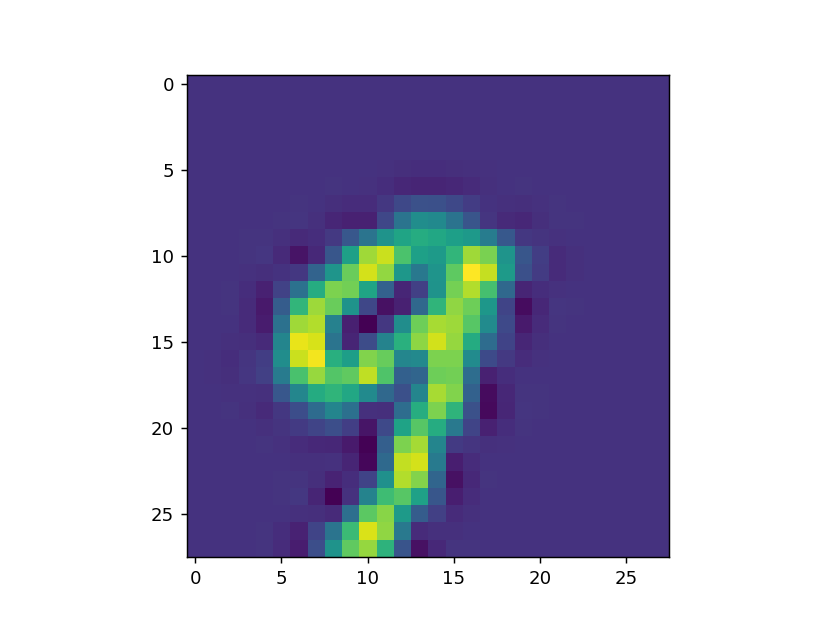

<IPython.core.display.Javascript object>


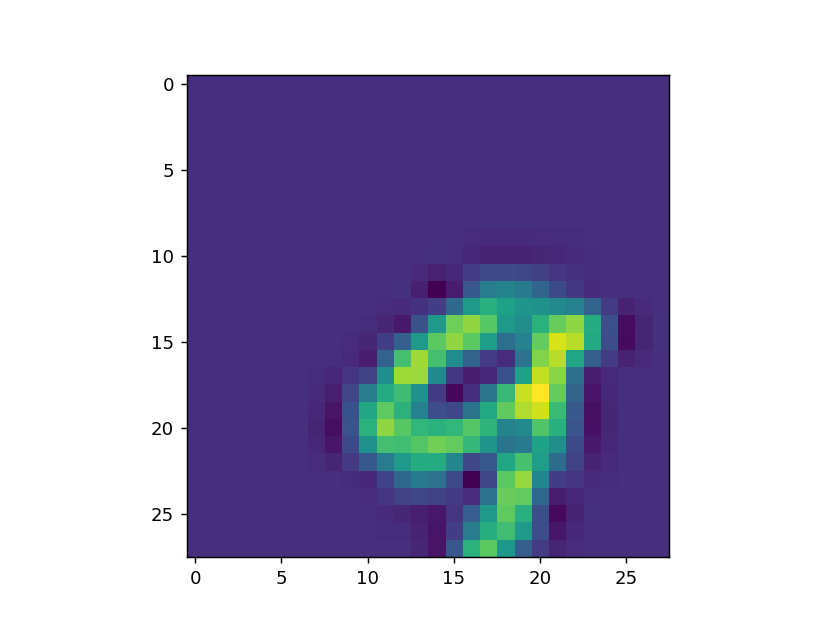

<IPython.core.display.Javascript object>


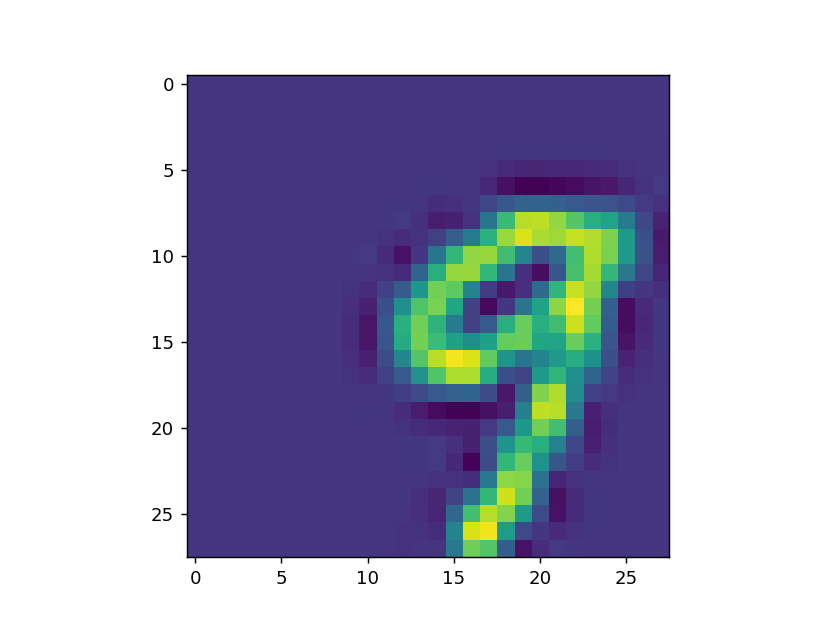

In [8]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [9]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, add_traject = True,trajectory_list=None):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.

    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    q_seq = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img_num,img in enumerate(images):
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        if trajectory_list is None:
            starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
            steps  = []
            for j in range(5):
                steps.append(starting_point*1)
                starting_point += np.random.randint(-5,5,2) 

            if mixed_state:
                q_sequence = np.array(steps).astype(int)
            else:
                if count == 0:
                    q_sequence = np.array(steps).astype(int)
        else:
            q_sequence = np.array(trajectory_list[img_num]).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        q_seq.append(q_sequence)
        count += 1
        

    
    if add_traject: #If we add the trjectories the train list will become a list of lists, the images and the 
        #corrosponding trajectories, we will change the dataset structure as well. Note the the labels stay the same.
        ts_train = [ts_images[:55000], q_seq[:55000]] 
        train_labels = labels[:55000]
        ts_val = [ts_images[55000:], q_seq[55000:]]
        val_labels = labels[55000:]

    else:
        ts_train = ts_images[:55000]
        train_labels = labels[:55000]
        ts_val = ts_images[55000:]
        val_labels = labels[55000:]

    dvs_train = dvs_images[:55000]
    dvs_val = dvs_images[55000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, add_traject = False, transform = None):

            self.data = data
            self.labels = labels

            self.add_traject = add_traject
            self.transform = transform
        def __len__(self):
            if self.add_traject: 
                return len(self.data[0]) 
            else: return len(self.data[0])


        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            if self.add_traject:
                img_data = self.data[0][idx] 
                traject_data = self.data[1][idx]
                label = self.labels[idx]
                return img_data, traject_data, label
            else:
                data = self.data[idx]



            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels
        
    train_dataset = mnist_dataset(ts_train, train_labels,add_traject = True)
    test_dataset = mnist_dataset(ts_val, val_labels,add_traject = True)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    
    return train_dataloader, test_dataloader, ts_train, train_labels

In [12]:
len(ts_train[1])
class mnist_dataset(Dataset):
    def __init__(self, data, labels, add_traject = False, transform = None):

        self.data = data
        self.labels = labels
        
        self.add_traject = add_traject
        self.transform = transform
    def __len__(self):
        if self.add_traject: 
            return len(self.data[0]) 
        else: return len(self.data[0])
        

    def __getitem__(self, idx):
        '''
        args idx (int) :  index

        returns: tuple(data, label)
        '''
        if self.add_traject:
            img_data = self.data[0][idx] 
            traject_data = self.data[1][idx]
            label = self.labels[idx]
            return img_data, traject_data, label
        else:
            data = self.data[idx]

        

        if self.transform:
            data = self.transform(data)
            return data, label
        else:
            return data, label

    def dataset(self):
        return self.data
    def labels(self):
        return self.labels
train_dataset = mnist_dataset(ts_train, train_labels, add_traject = True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)

NameError: name 'ts_train' is not defined

In [11]:
# with open('../../rlnet1/saved_runs/run_syclop_resolution101.py_noname__1619122748__10621//position_records.pkl','rb') as f:
with open('../../rlnet1/saved_runs/run_syclop_resolution101.py_noname__1619373185__66929//position_records.pkl','rb') as f:
    trajectory_list = pickle.load(f)


In [25]:
for batch_idx, (img, traject, targets) in enumerate(train_dataloader):
    print(img.shape, traject.shape, targets.shape)
    break
print(data[0], len(data[1]), data[1][0].shape, data[1][1].shape, data[1][2].shape)
data[1][1][1], data[0]

torch.Size([64, 5, 28, 28]) torch.Size([64, 10, 2]) torch.Size([64])


NameError: name 'data' is not defined

In [29]:
np.shape(ts_train[0])

(55000, 5, 28, 28)

In [10]:
train_dataloader, test_dataloader, ts_train, train_labels = create_dataset(images, labels,res = 28,trajectory_list=trajectory_list)

NameError: name 'trajectory_list' is not defined

In [26]:
len(trajectory_list)

60001

In [15]:
class RNN_Net(nn.Module):
    def __init__(self, traject = False):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        if traject:
            self.gru = nn.GRU(8*8*16 + 2,100)
        else:
            self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data, traject = None):
        if torch.cuda.is_available():
            hn = torch.zeros([1,data.shape[0],100]).double().to('cuda')
        else:
            hn = torch.zeros([1,data.shape[0],100]).double()
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            if traject is not None:
                traject_i = traject[:,i,:].double()
                img = torch.cat((img, traject_i),1) #Concatenate the trajectory to the flatten output 
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

In [16]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data, traject, targets) in enumerate(train_dataloader):
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
                traject = traject.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            optimizer.zero_grad()
            output = net(data.double(), traject.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
            
    
        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data, test_traject, test_targets) in enumerate(test_dataloader):
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                    test_traject = test_traject.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                test_output = net(test_data,test_traject)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
        
    return train_loss, test_loss, test_accur

In [32]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)

NameError: name 'CNN_one_layer' is not defined

In [142]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN(traject = True).double(), epochs = 4)

Net CNN Epoch :  1 	 loss : 0.0015413096034162326 accuracy : 97.80459
Net CNN Epoch :  2 	 loss : 0.003131342463717597 accuracy : 98.06171
Net CNN Epoch :  3 	 loss : 0.0027481074697087793 accuracy : 98.417725
Net CNN Epoch :  4 	 loss : 0.00042384479724387496 accuracy : 98.47706


### Regular conv net with regular data stacked works as well with more then 99% accuracy - let's push it into an RNN and see that we replecate the resilts before moving to lower resolutions. 

In [33]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 4)

Net RNN_Net Epoch :  1 	 loss : 0.12011433778213677 accuracy : 98.57595


KeyboardInterrupt: 

### Mooving on to lower resolutions 

<IPython.core.display.Javascript object>


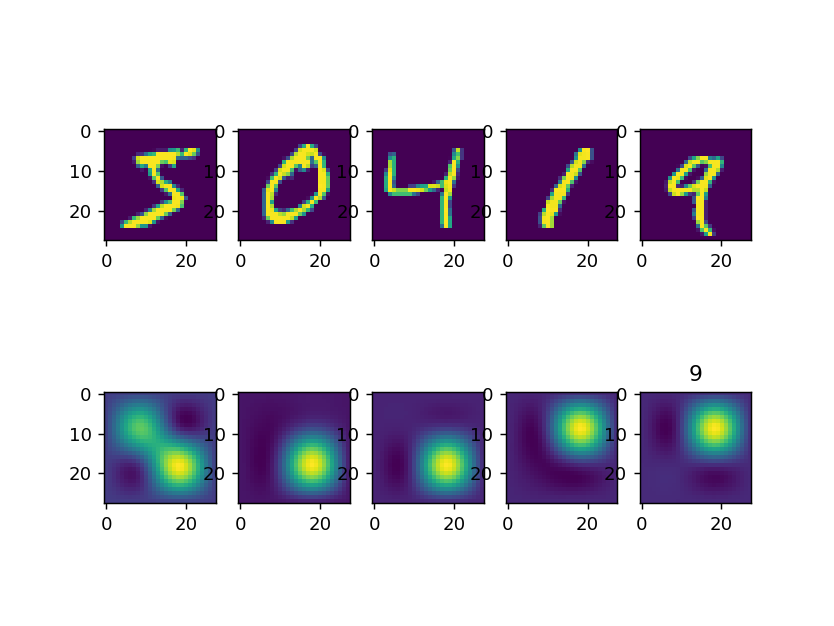

In [13]:
#Load the training data
train_dataloader, test_dataloader, _,_= create_dataset(images, labels,res = 6,trajectory_list=trajectory_list)

In [17]:
#Run the CNN+RNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 50)

Net RNN_Net Epoch :  1 	 loss : 0.5812569999353874 accuracy : 78.71835
Net RNN_Net Epoch :  2 	 loss : 0.2387312798528076 accuracy : 81.68513
Net RNN_Net Epoch :  3 	 loss : 0.5001062206095087 accuracy : 82.89162
Net RNN_Net Epoch :  4 	 loss : 0.1575083807446565 accuracy : 84.77057
Net RNN_Net Epoch :  5 	 loss : 0.21122312752185446 accuracy : 84.533226
Net RNN_Net Epoch :  6 	 loss : 0.5729059618458361 accuracy : 84.889244
Net RNN_Net Epoch :  7 	 loss : 0.4796881108907246 accuracy : 85.44304
Net RNN_Net Epoch :  8 	 loss : 0.8264857916753031 accuracy : 85.067245
Net RNN_Net Epoch :  9 	 loss : 0.24484734236617622 accuracy : 86.35285
Net RNN_Net Epoch :  10 	 loss : 0.2985681895668165 accuracy : 86.23418
Net RNN_Net Epoch :  11 	 loss : 0.21623097000969932 accuracy : 85.30459
Net RNN_Net Epoch :  12 	 loss : 0.08871290588525639 accuracy : 86.25395
Net RNN_Net Epoch :  13 	 loss : 0.6240122182630722 accuracy : 85.83861
Net RNN_Net Epoch :  14 	 loss : 0.3685655993947694 accuracy : 86.

KeyboardInterrupt: 

In [18]:
#Load the training data
import random
random.shuffle(trajectory_list)

<IPython.core.display.Javascript object>


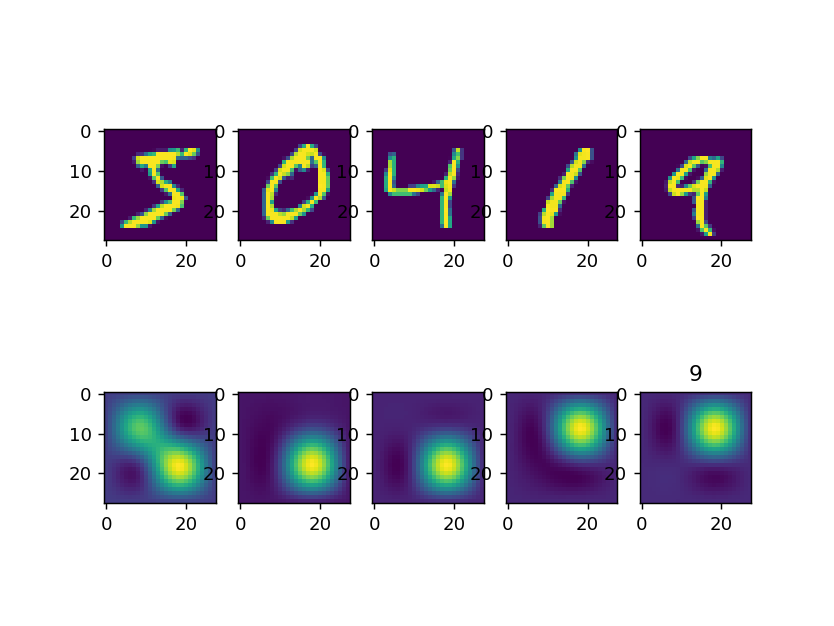

In [19]:
train_dataloader, test_dataloader, _,_= create_dataset(images, labels,res = 6,trajectory_list=trajectory_list)

In [20]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 50)

Net RNN_Net Epoch :  1 	 loss : 0.2118139045445194 accuracy : 79.173256
Net RNN_Net Epoch :  2 	 loss : 1.147379481644648 accuracy : 81.34889
Net RNN_Net Epoch :  3 	 loss : 0.3269295159248005 accuracy : 82.17959
Net RNN_Net Epoch :  4 	 loss : 0.5614087393735518 accuracy : 82.71361
Net RNN_Net Epoch :  5 	 loss : 0.3647096523252521 accuracy : 84.177216
Net RNN_Net Epoch :  6 	 loss : 1.1483483449379566 accuracy : 83.544304
Net RNN_Net Epoch :  7 	 loss : 0.49188397880050533 accuracy : 84.63212
Net RNN_Net Epoch :  8 	 loss : 0.5339998951118465 accuracy : 84.45412
Net RNN_Net Epoch :  9 	 loss : 0.8761691339040796 accuracy : 84.19699
Net RNN_Net Epoch :  10 	 loss : 0.13021613745000035 accuracy : 84.81013
Net RNN_Net Epoch :  11 	 loss : 0.16989103217799104 accuracy : 85.245255
Net RNN_Net Epoch :  12 	 loss : 1.102273672581109 accuracy : 85.12658
Net RNN_Net Epoch :  13 	 loss : 0.6634296042494328 accuracy : 84.47389
Net RNN_Net Epoch :  14 	 loss : 1.2503526948011499 accuracy : 85.10

<IPython.core.display.Javascript object>


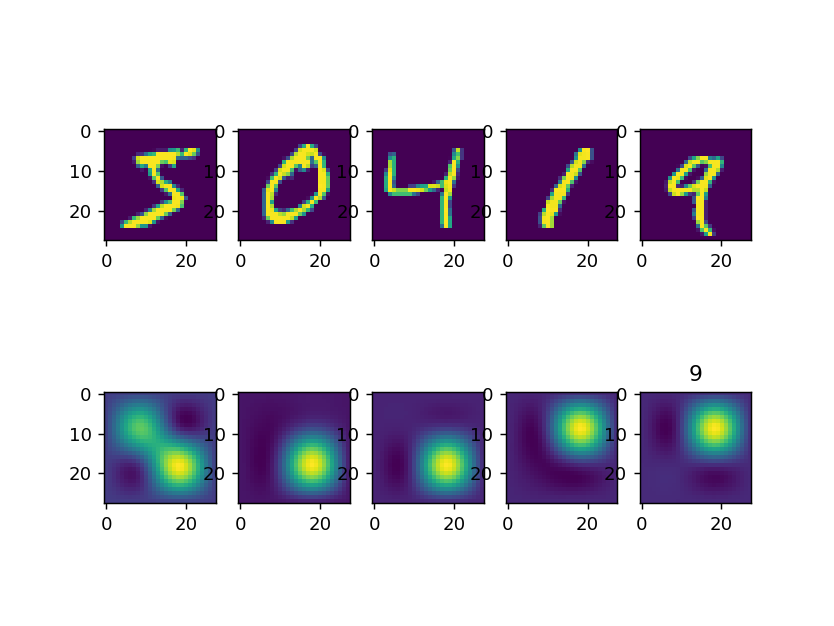

In [22]:
train_dataloader, test_dataloader, _,_= create_dataset(images, labels,res = 6)

In [ ]:
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net(traject = True).double(), epochs = 50)

Net RNN_Net Epoch :  1 	 loss : 2.301073089863279 accuracy : 47.033226
Net RNN_Net Epoch :  2 	 loss : 0.8111181418866347 accuracy : 52.74921
Net RNN_Net Epoch :  3 	 loss : 1.279854095231956 accuracy : 55.656647
Net RNN_Net Epoch :  4 	 loss : 1.6118031310158323 accuracy : 56.447784
Net RNN_Net Epoch :  5 	 loss : 1.8098980923166184 accuracy : 57.43671
Net RNN_Net Epoch :  6 	 loss : 1.1558182709753977 accuracy : 59.157436
Net RNN_Net Epoch :  7 	 loss : 1.1513983814062139 accuracy : 59.157436
Net RNN_Net Epoch :  8 	 loss : 1.8740988571553368 accuracy : 60.482594
Net RNN_Net Epoch :  9 	 loss : 1.3160540783639065 accuracy : 60.996834
Net RNN_Net Epoch :  10 	 loss : 1.5761483486179748 accuracy : 61.886868
Net RNN_Net Epoch :  11 	 loss : 1.2089025327444562 accuracy : 62.46044
Net RNN_Net Epoch :  12 	 loss : 0.9871983802328375 accuracy : 62.935127
Net RNN_Net Epoch :  13 	 loss : 0.8266400632303518 accuracy : 60.838608
Net RNN_Net Epoch :  14 	 loss : 0.6457934362183485 accuracy : 63